## Weather regimes.

Reference: Grams, C. M., Beerli, R., Pfenninger, S., Staffell, I., & Wernli, H. (2017). Balancing Europe’s wind-power output through spatial deployment informed by weather regimes. Nature Climate Change, 7(8), 557–562. doi:10.1038/nclimate3338 

Fort North American WR: Lee, S. H., Tippett, M. K., & Polvani, L. M. (2023). A New Year-Round Weather Regime Classification for North America. Journal of Climate, 36(20), 7091–7108. https://doi.org/10.1175/JCLI-D-23-0214.1

For Mediterranean WR: Mastrantonas N, Herrera-Lormendez P, Magnusson L, Pappenberger F, Matschullat J. Extreme precipitation events in the Mediterranean: Spatiotemporal characteristics and connection to large-scale atmospheric flow patterns. Int J Climatol. 2021; 41: 2710–2728. https://doi.org/10.1002/joc.6985

The Atlantic-European weather regime definition is based on standard approaches using empirical orthogonal function (EOF) analysis and k-means clustering. 

EOF analysis is performed on the 10-day low-pass-filtered geopotential height anomaly (using a 90-day running mean at the respective calendar time as reference climatology) at 500 hPa (Z5000) in the domain 80◦ W to 40◦ E, 30◦ N to 90◦.

Similar approches are used for the other papers, for the Mediterranean weathe regimes the region is and SLP is used instead:

- #### Steps: 
    1. compute daily means from 6 hourly data.
    2. compute smoothed (90-60)-day climatology and compute the anomaly. 
    3. use a 10-days lowpassfilter on the data.
    4. Detrend the data by removing the area-weighted mean trend. 
    5. Normalize the anomalies by the seasonal cycle in domain-average Z500 anomaly variance. Computing at each grid point the temporal standard deviation in a running 30-day window for each calendar time,and normalising Z500’by the spatial mean of this running standard deviation in the EOF domain.
    6. compute the leading 7 EOFS (we can change that to 10 or 12 like Lee et al)
    10. we aply the k-means cluster to this leading eofs. 10 times to have convergence. (this is depends on the paper)


In [214]:
import numpy as np 
import xarray as xr

In [215]:
import sys
sys.path.append('/home/bernatj/')


In [216]:
#slp 6hourly
#f= '/pool/datos/reanalisis/era5/6hourly/northern_hemisphere/075/slp/mean_sea_level_pressure_6h_era_5_*.nc'
#slp_6h =  xr.open_mfdataset(f).slp
f= '/home/bernatj/Data/my_data/era5/6hourly/z/z-era5-6h-*.nc'
slp_6h =  xr.open_mfdataset(f).z.sel(level=500)/9.806
slp_6h

<xarray.DataArray 'z' (time: 121264, latitude: 121, longitude: 240)>
dask.array<truediv, shape=(121264, 121, 240), dtype=float32, chunksize=(1464, 121, 240), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    level      int32 500
  * time       (time) datetime64[ns] 1940-01-01 ... 2022-12-31T18:00:00

In [217]:
#List of main options

#data period
start_date='1940-01-01'
end_date='2022-12-31'

#resolution to interpolate in degrees
res = 1.0

#region
#mediterranean
latN = 50.
latS = 26.
lonW = -11.
lonE = 41.

#N. American
#latN = 80.
#latS = 20.
#lonW = -178.
#lonE = -30.

#N. Atlantic
#latN = 90.
#latS = 30.
#lonW = -90.
#lonE = 40.

#number of EOFs
n_eofs = 12

#clustering options
n_clusters = 5
#n_clusters = 'auto'

In [219]:
#calculate daily means and fix data format
from Scripts.useful_fuctions.python_functions import fix_data_format, regrid_to_regular_grid

#fix data format
slp_6h = fix_data_format(slp_6h)

#interpolate to a desired regular grid (this includes the domain selection)
lat = np.arange(latS,latN+res,res)
lon = np.arange(lonW,lonE+res,res)
slp_6h = regrid_to_regular_grid(slp_6h,lon,lat)

#STEP1: compute daily means from 6 hourly data and slect period and region
slp_dm = slp_6h.sel(time=slice(start_date,end_date)).resample(time='1D').mean('time')


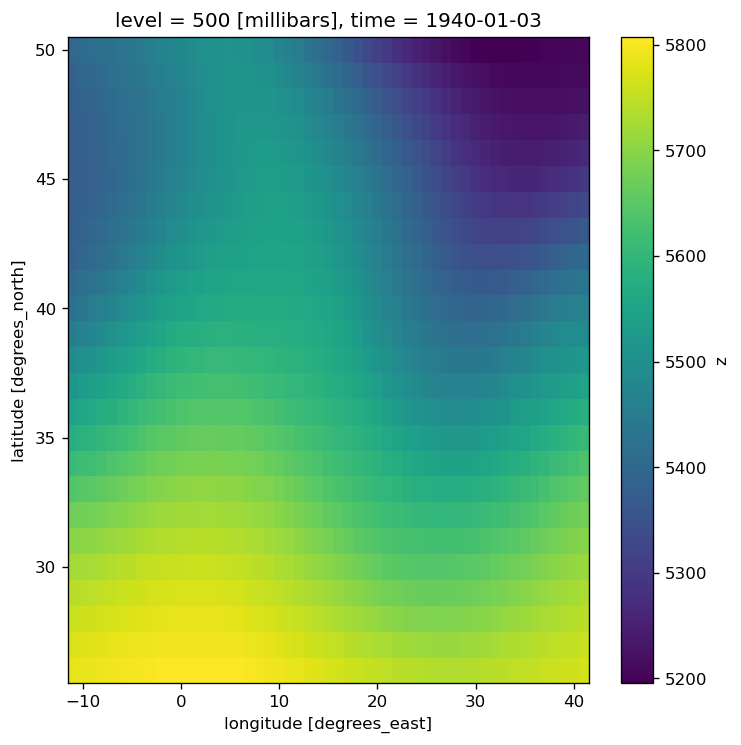

In [220]:
slp_dm[2].plot()

In [221]:
#STEP 2: compute smoothed 90-day climatology and compute the anomaly. 

#we remove the seasonal cycle by subtracting a 60-day running-mean climatology
slp_dm_climaology = slp_dm.groupby('time.dayofyear').mean('time')

# Pad the data using circular padding
padded_data = slp_dm_climaology.pad(dayofyear=(30, 30), mode='wrap')

# Apply the rolling window with circular boundary conditions
smoothed_climatology = padded_data.rolling(dayofyear=60, center=True, min_periods=1).mean().isel(dayofyear=slice(30, -30))

#compute anomaly
slp_dm_anom = slp_dm.groupby('time.dayofyear') - smoothed_climatology

/home/bernatj/miniconda3/envs/bernatj-stream-env/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


In [222]:
#STEP 3: apply 10-days lowpassfilter
from Scripts.diagnostics.statistical_methods import butter_lowpass_filter

fs = 1.0      # sample rate, 1/d
cutoff = 1/10 

slp_dm_anom_lf = butter_lowpass_filter(slp_dm_anom, cutoff, fs, order=5)


In [223]:
print(slp_dm_anom_lf)
print(slp_dm_anom)

<xarray.DataArray 'z' (time: 30316, lat: 25, lon: 53)>
array([[[  -6.9904821 ,   -3.12096217,    1.07690187, ...,
           60.58202765,   62.00513764,   63.40823005],
        [ -17.55958473,  -13.46599103,   -9.22722128, ...,
           64.16329412,   66.68910084,   68.85698169],
        [ -29.53559232,  -25.30415054,  -20.84691474, ...,
           65.56541092,   68.64140173,   71.23486052],
        ...,
        [ -66.80642189,  -52.65621466,  -38.73948541, ...,
         -167.19544354, -159.44974115, -151.04355546],
        [ -41.18044442,  -27.60147658,  -14.72337612, ...,
         -187.8292931 , -181.81284384, -175.08164012],
        [ -16.40438671,   -3.80477381,    7.73872862, ...,
         -206.39380477, -202.05135786, -196.93101246]],

       [[   4.40785078,    8.0097302 ,   11.76602103, ...,
           29.15999227,   29.96661675,   30.86803399],
        [  -1.76884577,    1.95751819,    5.68303183, ...,
           31.94947762,   33.61888686,   35.12922935],
        [  -9.6020

In [224]:
#STEP 4: Detrend the data by removing the area-weighted mean trend. 

weights = np.cos(slp_dm_anom_lf.lat  * np.pi/180)
area_weighted_slp = (slp_dm_anom_lf.mean('lon') * weights).sum('lat') / weights.sum('lat')

def linear_fit_xarray(input_xarray, dim_name='dim'):
    # Extract the coordinates and data from the xarray
    data = input_xarray.values
    coords = np.arange(0, data.size, 1)
    
    # Use numpy's polyfit function to fit a linear polynomial (degree 1)
    slope, intercept = np.polyfit(coords, data, 1)
    
    # Compute the linear fit for each coordinate
    linear_fit_values = slope * coords + intercept
    
    # Create a new xarray with the same coordinates and dimensions
    output_xarray = input_xarray.copy(data=linear_fit_values, deep=False)
    
    return output_xarray

area_weighted_slp_linearfit = linear_fit_xarray(area_weighted_slp, 'time')
slp_dm_anom_lf_dtrended = slp_dm_anom_lf - area_weighted_slp_linearfit 

In [225]:
#STEP 5: Standarization by the area averaged variance

slp_std_doy = slp_dm_anom_lf_dtrended.groupby('time.dayofyear').std('time')

# Apply the rolling window with circular boundary conditions

# Pad the data using circular padding
padded_data_std = slp_std_doy.pad(dayofyear=(15, 15), mode='wrap')

# Define a rolling window size
window_size = 30

# Define a function to calculate the combined standard deviation
def combine_std(da_slice):
    squared_sum = (da_slice ** 2).sum(dim='dayofyear')
    combined_std = (squared_sum / window_size) ** 0.5
    return combined_std

# Create an empty array to store the results
smoothed_std_values = np.empty_like(padded_data_std)

# Apply the rolling operation with the custom function
for i in range(len(padded_data_std['dayofyear'])):
    da_slice = padded_data_std.isel(dayofyear=slice(i - window_size//2, i + window_size//2 + 1))
    smoothed_std_values[i] = combine_std(da_slice)

# Create a new DataArray with the smoothed values
smoothed_std = xr.DataArray(smoothed_std_values, coords=padded_data_std.coords)
smoothed_std = smoothed_std.isel(dayofyear=slice(window_size//2, -window_size//2))

In [226]:
#We perform this normalization in order to retain the structure of the variance within the domain, 
#while ensuring the total field variance does not have a seasonal cycle (thus giving equal weight to summer and winter days within the k-means algorithm).

#area weighted average
weights = np.cos(smoothed_std.lat * np.pi/180)
area_weighted_std = (smoothed_std.mean('lon') * weights).sum('lat') / weights.sum('lat')

#normalized the field

# Define a function for the division operation
def divide_by_area_weighted_std(group):
    return group / area_weighted_std.sel(dayofyear=group.dayofyear)

# Apply the division operation for each group (dayofyear)
slp_pre_eofs = slp_dm_anom_lf_dtrended.groupby('dayofyear').apply(divide_by_area_weighted_std)

In [227]:
#STEP 6: Apply EOFs
from eofs.xarray import Eof

# create a solver class, taking advantage of built-in weighting
weights = (np.cos(smoothed_std.lat * np.pi / 180))**0.5
solver = Eof(slp_pre_eofs.transpose("time", "lon", "lat"), center=True, weights=weights)

# retrieve the EOFs from the solver class
#eofs = solver.eofs(neofs=n_eofs).transpose("mode", "lat", "lon")
#eofs_cov = solver.eofsAsCovariance(neofs=n_eofs,pcscaling=1).transpose("mode", "lat", "lon")
#pcs = solver.pcs(npcs=n_eofs, pcscaling=1)

var_frac = solver.varianceFraction(neigs=n_eofs) #explained varience
slp_reconstructed_field = solver.reconstructedField(neofs=n_eofs).transpose('time','lat','lon')

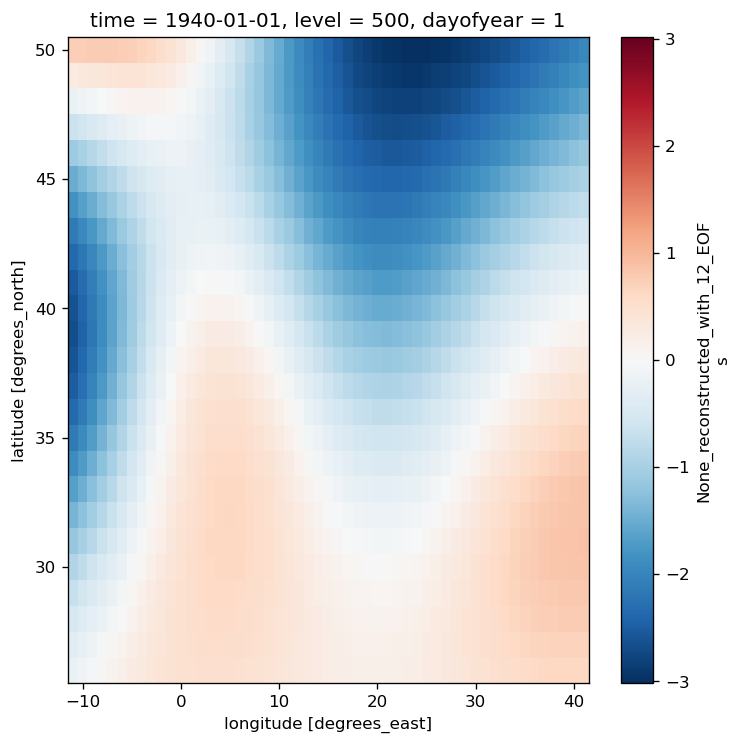

In [228]:
slp_reconstructed_field[0].plot()

In [229]:
#save the data in a netcdf file
file_path = '/home/bernatj/Workdir/analysis_WR/Data/z500_MED_1940-2022_12EOFS_preporcessed_before_kmeans.nc'
ds =  xr.Dataset(coords=slp_reconstructed_field.transpose("time", "lat", "lon").coords)
ds = ds.assign(SLP_after_eofs = slp_reconstructed_field.transpose("time", "lat", "lon"))
ds = ds.assign(SLP_pre_eofs = slp_pre_eofs)
ds = ds.assign(SLP_dm_anom = slp_dm_anom)
ds.to_netcdf(file_path, format='NETCDF4')


In [230]:
#read the after_eofs SLP field
file_path = '/home/bernatj/Workdir/analysis_WR/Data/z500_MED_1940-2022_12EOFS_preporcessed_before_kmeans.nc'
slp_reconstructed_anom = xr.open_mfdataset(file_path).SLP_after_eofs
slp_dm_anom = xr.open_mfdataset(file_path).SLP_dm_anom

In [231]:
#STEP 7. Compute the k-means cluster analysis:
from sklearn.cluster import KMeans
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

def Kmeans_Z500_with_no_regime_as_cluster(Z500_anomalies, n_clusters, random_state, n_init):
    # Reshape the data to 2D (time, lat*lon) for k-means clustering
    Z500_reshaped = Z500_anomalies.stack(points=['lat', 'lon'])

    # Perform K-means clustering with initialized centroids
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state).fit(Z500_reshaped)

    # Extract cluster labels and adjust numbering to start from 1
    output_kmeans = kmeans.labels_ + 1

    # Calculate distances to cluster centroids
    distances_to_centroids = np.linalg.norm(kmeans.cluster_centers_[output_kmeans - 1] - Z500_reshaped.values, axis=1)

    # Calculate distances to climatology
    climatology_distances = np.linalg.norm(Z500_reshaped.values - np.mean(Z500_reshaped.values, axis=0), axis=1)

    # Find days closer to climatology than any of the cluster centroids
    no_regime_mask = climatology_distances < distances_to_centroids

    # Assign a special label (e.g., 0) to days with no regime
    output_kmeans[no_regime_mask] = 0

    return output_kmeans

# Example usage:
# output_kmeans = Kmeans_Z500_with_no_regime_as_cluster(slp_reconstructed_anom, 7, random_state=0, n_init=10)


def Kmeans_Z500(Z500_anomalies, n_clusters, random_state, n_init):
    """
    Perform K-means clustering on Z500 anomalies.

    Parameters:
    - Z500_anomalies (xarray.DataArray): Anomalies of Z500 variable.
    - n_clusters (int): The number of clusters to form.
    - random_state (int): Determines random number generation for centroid initialization.
    - n_init (int): Number of times the k-means algorithm will be run with different centroid seeds.

    Returns:
    - output_kmeans (numpy.ndarray): Cluster labels for each point in the reshaped Z500 anomalies.
    - inertia (float): Sum of squared distances from each point to its assigned center.

    The function performs K-means clustering on the anomalies of Z500 variable. The input anomalies
    are expected to be in the form of an xarray DataArray with dimensions ('time', 'lat', 'lon').

    The data is first reshaped to 2D (time, lat*lon) to apply k-means clustering. The result
    includes cluster labels for each point and the inertia, which is the sum of squared distances
    from each point to its assigned center.

    Parameters:
    - Z500_anomalies: 3D xarray.DataArray with dimensions ('time', 'lat', 'lon').
    - n_clusters: Number of clusters to form.
    - random_state: Determines random number generation for centroid initialization.
    - n_init: Number of times the k-means algorithm will be run with different centroid seeds.

    Returns:
    - output_kmeans: 1D numpy array of cluster labels for each point in the reshaped Z500 anomalies.
    - inertia: Float, the sum of squared distances from each point to its assigned center.
    """
    # Reshape the data to 2D (time, lat*lon) for k-means clustering
    Z500_reshaped = Z500_anomalies.stack(points=['lat', 'lon'])

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init).fit(Z500_reshaped)

    # Extract cluster labels and adjust numbering to start from 1
    output_kmeans = np.copy(kmeans.labels_)
    output_kmeans = output_kmeans + 1  # Adjust numbering to start from 1

    return output_kmeans, kmeans.inertia_


def ACC(array_1, array_2):
    """
    Compute the Anomaly Correlation Coefficient (ACC) between two arrays.

    Parameters:
    - array_1 (xarray.DataArray): First input array.
    - array_2 (xarray.DataArray): Second input array.

    Returns:
    - float: Anomaly Correlation Coefficient.

    The Anomaly Correlation Coefficient is a measure of the similarity between
    two arrays, often used in meteorology to assess the performance of a
    forecast model.

    Formula:
    ACC = mean(FC * OBS) / sqrt(mean(FC**2) * mean(OBS**2))

    where FC is the flattened array_1 values, OBS is the flattened array_2 values,
    mean() calculates the mean of the element-wise product or square, and sqrt()
    is the square root function.

    Reference:
    http://metclim.ucd.ie/wp-content/uploads/2017/07/DeterministicSkillScore.pdf
    """
    FC = np.array(array_1.ravel())
    OBS = np.array(array_2.ravel())
    top = np.mean((FC) * (OBS))
    bottom = np.sqrt(np.mean((FC)**2) * np.mean((OBS)**2))
    ACC = top / bottom
    return ACC

def plot_no_kmeans_evolution(no_clusters_min, no_clusters_max, sum_square_distance_per_no_cluster, AAC_avg_per_no_cluster, AAC_max_per_no_cluster, path_out):
    #This function plots some statistics conditional on the number of WRs so we can choose the best number of WRs
    fig, ax1 = plt.subplots()
    x_axis = np.arange(no_clusters_min,no_clusters_max+1)
    ax1.plot(x_axis, sum_square_distance_per_no_cluster, 'k')
    #ax1.set_ylabel('Sum of squares (m)', color='k')
    ax1.set_ylabel('SS (m)', color='k')
    
    ax2 = ax1.twinx()
    ax2.plot(x_axis, AAC_max_per_no_cluster, 'r', label = 'max')  
    #ax2.plot(x_axis, AAC_avg_per_no_cluster, 'b', label = 'avg')
    ax2.set_ylabel('max ACC', color='k')
    ax1.set_xlabel('no clusters')
    plt.savefig (path_out, dpi=300, format='png', bbox_inches='tight')
    plt.close ()
    plt.clf   ()  

In [232]:
if n_clusters == 'auto':
    print('...doing Kmeans...')

    # Initialize lists to store results for each number of clusters
    sum_square_distance_per_no_cluster = []
    AAC_max_per_no_cluster = []
    AAC_avg_per_no_cluster = []

    # Loop over different numbers of clusters
    for num_clusters in range(4, 10 + 1):
        # Perform K-means clustering and get cluster labels
        label_samples_kmeans, sum_square_distance = Kmeans_Z500(slp_reconstructed_anom, num_clusters, random_state=0, n_init=500)
        sum_square_distance_per_no_cluster.append(sum_square_distance)

        print('...computing Anomaly Correlation Coefficient composites...')

        # Initialize array to store composites for each cluster
        composites_WRs = np.full([num_clusters, *slp_reconstructed_anom.shape[1:]], np.nan)

        # Loop over clusters and compute composites
        for cluster_num in range(1, num_clusters + 1):
            composites_WRs[cluster_num - 1, :, :] = np.mean(slp_reconstructed_anom[label_samples_kmeans == cluster_num, :, :], axis=0)

        # Initialize a list to store Anomaly Correlation Coefficients (ACC)
        list_anomalies_corr_coeff = []

        # Loop over pairs of clusters and compute ACC
        for i in range(1, num_clusters + 1):
            for j in range(i + 1, num_clusters + 1):
                list_anomalies_corr_coeff.append(ACC(composites_WRs[i - 1, :, :], composites_WRs[j - 1, :, :]))

        # Store maximum and average ACC for the current number of clusters
        AAC_max_per_no_cluster.append(np.max(list_anomalies_corr_coeff))
        AAC_avg_per_no_cluster.append(np.mean(list_anomalies_corr_coeff))

    # Plot evolution of metrics for different numbers of clusters
    plot_no_kmeans_evolution(4, 10, sum_square_distance_per_no_cluster,
                             AAC_avg_per_no_cluster, AAC_max_per_no_cluster,
                             '/home/bernatj/Workdir/analysis_WR/Med_z500_Kmeans_evolution.png')

else:
    output_kmeans = Kmeans_Z500_with_no_regime_as_cluster(slp_reconstructed_anom, n_clusters, random_state=0, n_init=10)

In [244]:
# Create xarray DataArray
slp_composite = xr.DataArray(
    dims=('cluster', 'lat', 'lon'),
    coords={'cluster': np.arange(0, n_clusters + 1), 'lat': slp_dm_anom.lat, 'lon': slp_dm_anom.lon}
)

slp_composite_field = xr.DataArray(
    dims=('cluster', 'lat', 'lon'),
    coords={'cluster': np.arange(0, n_clusters + 1), 'lat': slp_dm_anom.lat, 'lon': slp_dm_anom.lon}
)

frequency = []
for cluster in range(0, n_clusters + 1):    
    i_cluster = np.where(output_kmeans == cluster)[0]
    print(i_cluster)
    frequency.append(len(i_cluster)/len(output_kmeans))
    # composite mean
    slp_composite[cluster] = slp_dm_anom.isel(time=i_cluster).mean('time')
    slp_composite_field[cluster] = slp_dm.isel(time=i_cluster).mean('time')

[    3     4    10 ... 30283 30284 30285]
[   52    53    54 ... 30313 30314 30315]
[   15    16    17 ... 30297 30298 30299]
[    5     6     7 ... 30173 30226 30237]
[    0     1     2 ... 30224 30276 30277]
[   33    34    35 ... 30300 30301 30302]


In [237]:
import numpy as np
import xarray as xr

# Assuming slp_dm_anom has a 'time' dimension
# You can create a seasons variable based on months
seasons = slp_dm_anom['time.month']
seasons = xr.where((seasons >= 3) & (seasons <= 5), 'DJF',
                   xr.where((seasons >= 6) & (seasons <= 8), 'MAM',
                            xr.where((seasons >= 9) & (seasons <= 11), 'JJA',
                                     xr.where((seasons == 12) | (seasons <= 2), 'SON', 'Unknown'))))

# Create xarray DataArray for composite
slp_composite = xr.DataArray(
    dims=('cluster', 'lat', 'lon', 'season'),
    coords={'cluster': np.arange(0, n_clusters + 1), 'lat': slp_dm_anom.lat, 'lon': slp_dm_anom.lon,
            'season': ['DJF', 'MAM', 'JJA', 'SON']}  # Modify as per your desired seasons
)

# Frequency of each cluster
cluster_frequencies = []

for cluster in range(n_clusters + 1):
    cluster_season_freq = []

    for season in slp_composite['season']:
        # Select data for the current cluster and season
        i_cluster_season = np.where((output_kmeans == cluster) & (seasons == season))[0]
        cluster_season_freq.append(len(i_cluster_season) / len(output_kmeans))

        # Composite mean
        #slp_composite.loc[{'cluster': cluster, 'season': season}] = slp_dm_anom.isel(time=i_cluster_season).mean('time')
        slp_composite.loc[{'cluster': cluster, 'season': season}] = slp_dm_anom_lf.isel(time=i_cluster_season).mean('time')
    cluster_frequencies.append(cluster_season_freq)

# Print the frequency of each cluster in each season
print("Cluster Frequencies:")
for i, freq in enumerate(cluster_frequencies):
    for j, season in enumerate(slp_composite['season']):
        print(f"Cluster {i}, Season {season}: {freq[j]:.2%}")

# Print the composite DataArray
print(slp_composite)


Cluster Frequencies:
Cluster 0, Season <xarray.DataArray 'season' ()>
array('DJF', dtype='<U3')
Coordinates:
    season   <U3 'DJF': 4.21%
Cluster 0, Season <xarray.DataArray 'season' ()>
array('MAM', dtype='<U3')
Coordinates:
    season   <U3 'MAM': 3.94%
Cluster 0, Season <xarray.DataArray 'season' ()>
array('JJA', dtype='<U3')
Coordinates:
    season   <U3 'JJA': 3.69%
Cluster 0, Season <xarray.DataArray 'season' ()>
array('SON', dtype='<U3')
Coordinates:
    season   <U3 'SON': 3.63%
Cluster 1, Season <xarray.DataArray 'season' ()>
array('DJF', dtype='<U3')
Coordinates:
    season   <U3 'DJF': 3.77%
Cluster 1, Season <xarray.DataArray 'season' ()>
array('MAM', dtype='<U3')
Coordinates:
    season   <U3 'MAM': 6.18%
Cluster 1, Season <xarray.DataArray 'season' ()>
array('JJA', dtype='<U3')
Coordinates:
    season   <U3 'JJA': 4.62%
Cluster 1, Season <xarray.DataArray 'season' ()>
array('SON', dtype='<U3')
Coordinates:
    season   <U3 'SON': 4.22%
Cluster 2, Season <xarray.DataArray

In [238]:
print(sum(frequency))

1.0


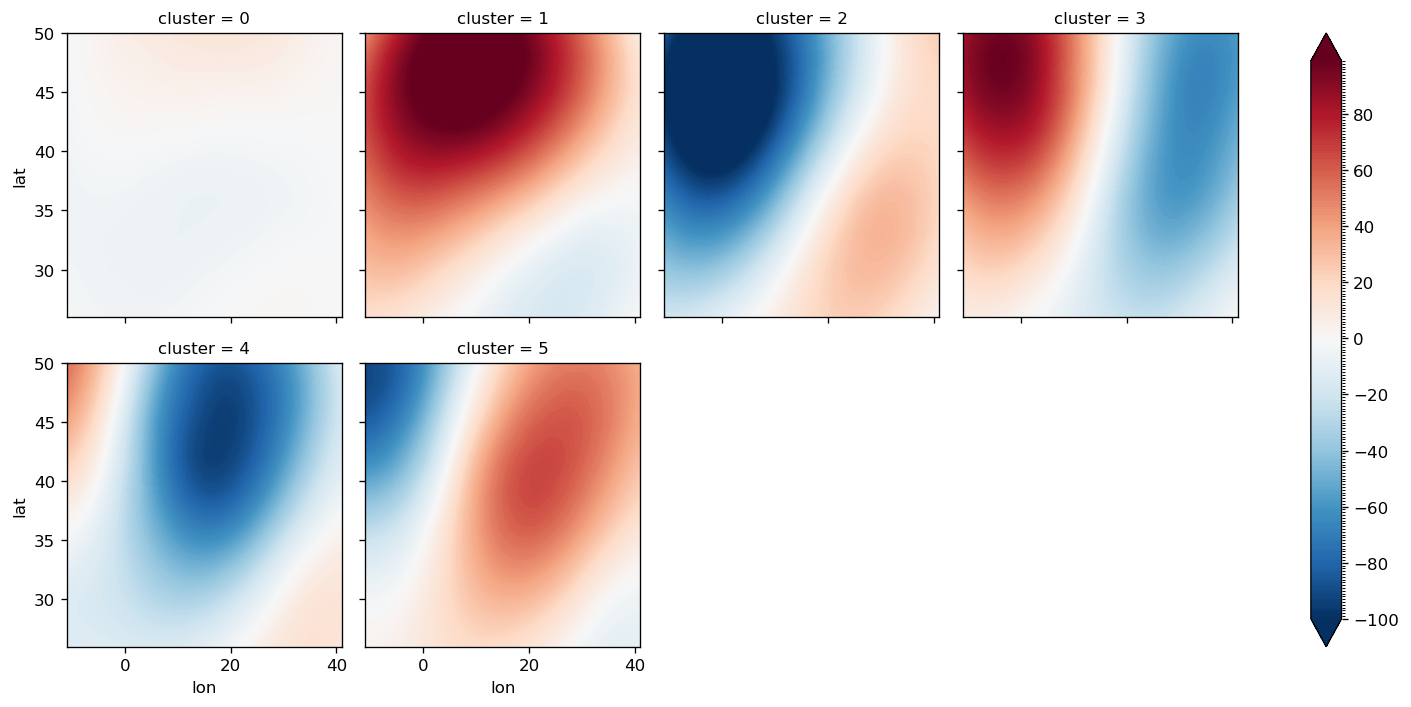

In [240]:
(slp_composite.sel(season='DJF')).plot.contourf(col='cluster', col_wrap=4, levels=np.arange(-100,100,1))

/tmp/ipykernel_4120150/576764322.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)
/home/bernatj/miniconda3/envs/bernatj-stream-env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


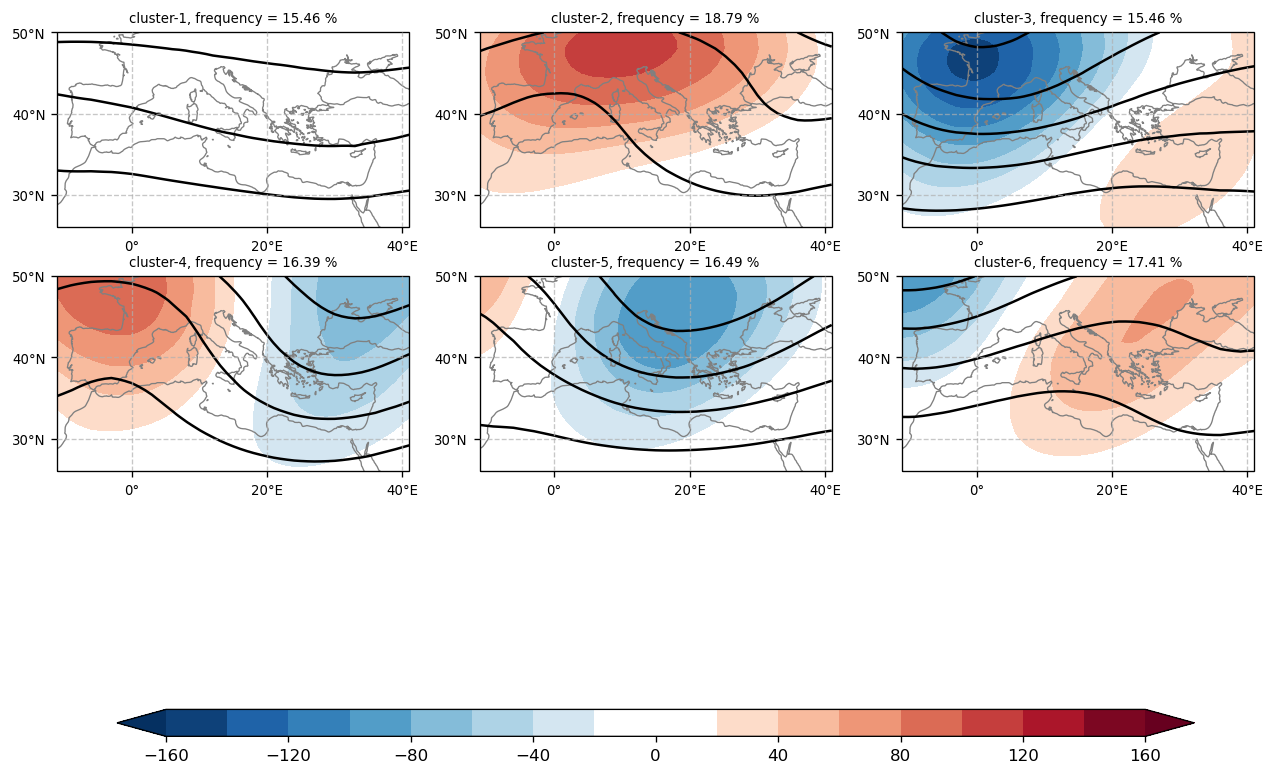

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

if n_clusters == 4:
    f, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(7.5,5.6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))
else:
# Create subplots with shared y-axis and manually share x-axis
    f, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10.5,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

lev = np.arange(-160,161,20)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = slp_composite.lat, slp_composite.lon
nLons = np.arange(-180, 181, 20)
nLats = np.arange(-90, 91, 10)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title(f"cluster-{i+1}, frequency = "+"{:.2f}".format((frequency[i]*100))+' %', fontsize=8)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([latS, latN])
        ax.set_xlim([lonW, lonE])
    
        ax.set_facecolor('0.8')
        ax.coastlines(lw=0.8, color='grey')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1.2)

        # Explicitly pass the ax parameter to contourf
        h = ax.contourf(lon, lat, slp_composite[i], cmap=newcmap, levels=lev, extend='both', alpha=1.0) 
        h2 = ax.contour(lon, lat, slp_composite_field[i],levels=lev2, colors='k', linewidth=1)
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
plt.savefig('MED_WR_12EOFs_6WR_z500_no_regime_1940-2022.pdf',bbox_inches='tight')

In [213]:
#save WR
cluster_occurence = xr.DataArray(data=output_kmeans, coords= {'time' : slp_dm_anom.time})

file_path = '/home/bernatj/Workdir/analysis_WR/Data/cluster_labels_Z500_NAE_7WR_10EOFs_1979-2015.nc'
ds =  xr.Dataset(coords = {'time' : cluster_occurence.time})
ds = ds.assign(cluster_occurence = cluster_occurence)
ds.to_netcdf(file_path, format='NETCDF4')



In [70]:
# WR index: projection of daily anomalies on the cluster mean (compopsite). then standarize:

# slp_composite and slp_dm_anom are xarray DataArrays with dimensions ('WR', 'lat', 'lon') and ('time', 'lat', 'lon'), respectively.

# Calculate the cosine of latitude once and store it in a separate DataArray
cos_lat = np.cos(np.radians(slp_dm_anom.lat))
cos_lat_da = xr.DataArray(cos_lat, dims='lat', coords={'lat': slp_dm_anom.lat})

# Perform the weighted projection using xarray operations
WR_ind = (slp_composite * slp_dm_anom * cos_lat_da).sum(dim=('lat', 'lon')) / cos_lat_da.sum()

# Standardize the index
WR_ind_standardized = ((WR_ind - WR_ind.mean('time')) / WR_ind.std('time')).compute()

# Display the resulting DataArray
print(WR_ind)



<xarray.DataArray (cluster: 7, time: 16071)>
dask.array<truediv, shape=(7, 16071), dtype=float64, chunksize=(7, 16071), chunktype=numpy.ndarray>
Coordinates:
  * cluster    (cluster) int64 1 2 3 4 5 6 7
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
    level      (time) int32 dask.array<chunksize=(16071,), meta=np.ndarray>
    dayofyear  (time) int64 dask.array<chunksize=(16071,), meta=np.ndarray>


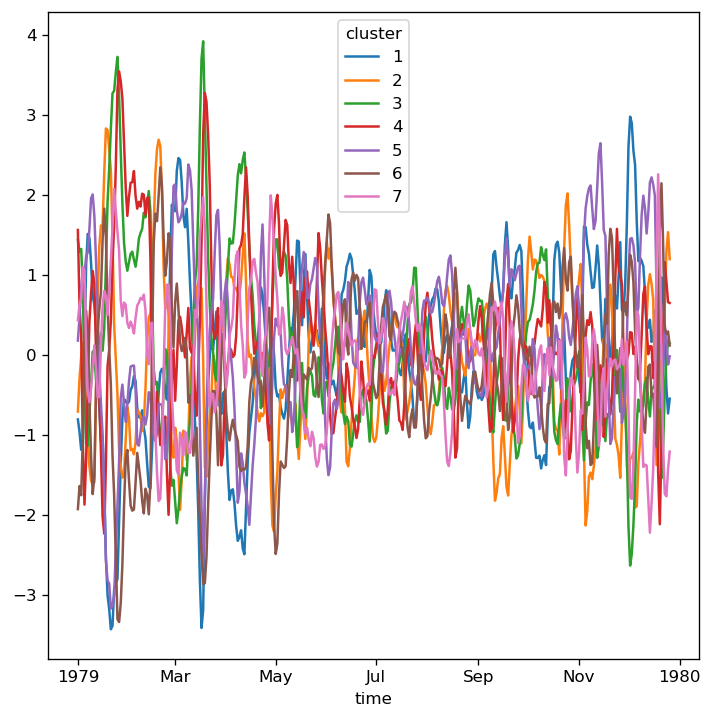

In [69]:
WR_ind_standardized[:,0:360].plot.line(hue='cluster')

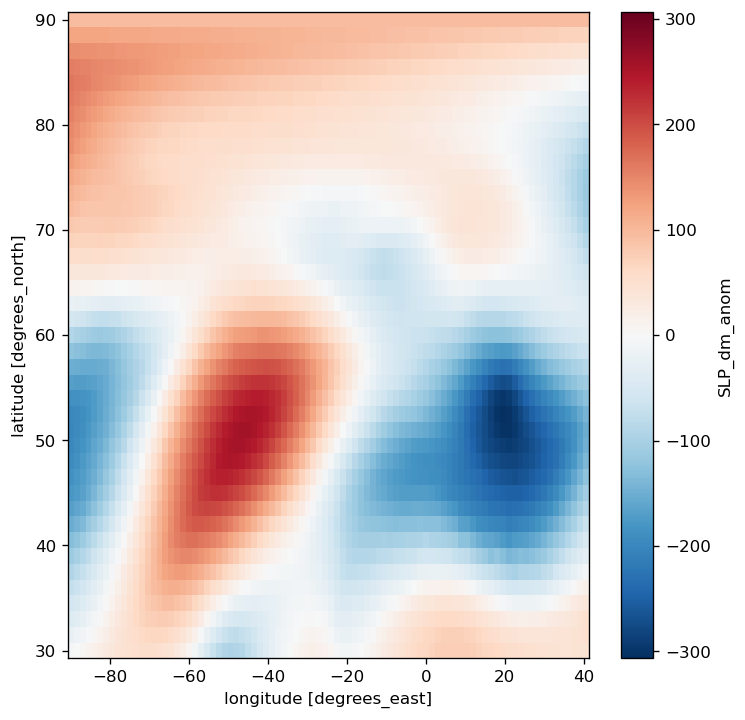

In [64]:
slp_dm_anom[0:5].mean('time').plot()

In [68]:
# Assuming you have already calculated WR_ind for each cluster

# Create a binary mask indicating where WR_ind is above 0.5 for any cluster
above_threshold_mask = (WR_ind_standardized > 0.5).any(dim='cluster')

# Convert the Dask array to a NumPy array using .compute()
above_threshold_mask_np = above_threshold_mask.compute()

# Count the frequency of occurrences for each time step
frequency_of_occurrences = above_threshold_mask_np.sum(dim='time')

# Display the frequency of occurrences
print(frequency_of_occurrences.values/above_threshold_mask_np.size * 100)


94.19451185364943


In [45]:
above_threshold_mask_np.size 

16071